# Scraping

In [10]:
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

## 1. Selenium
## 1.1 Scrape links

In [48]:
url = "https://ec.europa.eu/commission/presscorner/home/en?dotyp=&keywords=GHG&commissioner="
driver = webdriver.Chrome()
driver.get(url)

In [52]:
page_content = driver.find_element(By.ID, 'news-block')
# Now, find all <a> tags *within* that specific 'page_content' element
all_links= page_content.find_elements(By.TAG_NAME, 'a')

links = []
for link in all_links:
    href = link.get_attribute('href')
    text = link.text
    #print(f"Link Text: '{text}', URL: '{href}'")
    links.append(href)
links = [link for link in links if link!=None and len(link)>0]
links[:2]

['https://ec.europa.eu/commission/presscorner/detail/en/mex_25_1333',
 'https://ec.europa.eu/commission/presscorner/detail/en/mex_25_1287']

## 1.2 Scrape all links

In [87]:
#driver = webdriver.Chrome()
def scrape_page(url):
    driver.get(url)
    time.sleep(4)
    #page_title
    page_title = driver.find_element(By.TAG_NAME, 'h1').text
    #page_content
    page_content = driver.find_element(By.CLASS_NAME, 'ecl-col-l-9').text
    #date
    els = driver.find_elements(By.CLASS_NAME, 'ecl-page-header__meta-item')
    els = [el.text for el in els]
    date = next((item for item in els if re.search(r'\d{4}', item)), None)
    
    final_text = f"{page_title}\n{page_content}"
    return date.replace(",","").replace(" ", "_"), final_text

### 1.2.1 Example

In [63]:
date, final_text = scrape_page(links[1])
final_text[:400]

"Daily News 20 / 05 / 2025\nCommission welcomes political agreement on the progressive rollout of Europe's New Digital Border System\nThe European Commission welcomes yesterday's provisional political agreement by the European Parliament and the Council on the Commission's proposal for a progressive rollout of Europe's new digital border system, the Entry/Exit System (EES).\nThis agreement will allow "

### 1.2.2 Scrape all

In [65]:
scrape_dictionary = {}
from tqdm import tqdm
for link in tqdm(links):
    try:
        date, final_text = scrape_page(link)
        scrape_dictionary[date] = final_text
    except:
        print("LINK DIDNT WORK", link)


### 1.2.3 Convert results to data frame

In [82]:
import pandas as pd
df_text = pd.DataFrame.from_dict(scrape_dictionary, orient = 'index', columns = ['text'])
df_text.index.name = 'date'
df_text.tail(2)

,text
date,
Apr_12_2024,Questions and Answers on the revised Energy Pe...
Apr_5_2024,Commission approves €350 million German State ...


### 1.2.4 Export

In [83]:
import os
export_path = "../../data/examples/module_4"
os.listdir(export_path)

[]

In [85]:
file_name = f"{export_path}/eu_press_releases_ghg.csv"
df_text.to_csv(file_name)

In [88]:
pd.read_csv(file_name).head(2)

,date,text
0,May_26_2025,Daily News 26 / 05 / 2025\nEU organises firefi...
1,May_20_2025,Commission approves €1.2 billion Dutch State a...


# 2. Basic NLP

- https://manifesto-project.wzb.eu/information/documents/api

In [1]:
import sys
sys.path.append("../../..")
from src.data.download_manifesto import DownloadManifesto
dataset_key = "MPDS2024a"
version = '2024-1'
api_key = 'a7dd2e06ed14f5665e3e46b637387338'

In [2]:
# Usage example:
downloader =  DownloadManifesto(dataset_key, version, api_key)
result = downloader.get_country_data("Germany")
result

NameError: name 'ManifestoDownloader' is not defined

In [61]:

manifesto_api = DownloadManifesto(dataset_key, version, api_key)

In [ ]:
core_data = manifesto_api.get_core_data()
core_data

In [67]:
us_filtered_df = manifesto_api.filter_country(core_data, country = "United States")
us_filtered_df.head(2)

,countryname,party,partyname,date,keys
2562,United States,61320,Democratic Party,192011,61320_192011
2563,United States,61620,Republican Party,192011,61620_192011


In [68]:
metadata_response = manifesto_api.get_metadata(us_filtered_df['keys'].tolist())
us_filtered_df = manifesto_api.map_metadata(us_filtered_df, metadata_response)
us_filtered_df.head(2)

,countryname,party,partyname,date,keys,manifesto_id
2562,United States,61320,Democratic Party,192011,61320_192011,NaN
2563,United States,61620,Republican Party,192011,61620_192011,NaN


In [69]:
texts = manifesto_api.get_texts_and_annotations(us_filtered_df['manifesto_id'].tolist())
df_us_final = manifesto_api.prepare_final_data(us_filtered_df, texts)
df_us_final.head(2)

party         partyname          keys  manifesto_id  \
countryname   date                                                          
United States 196011  61320  Democratic Party  61320_196011  61320_196011   
              196011  61620  Republican Party  61620_196011  61620_196011   

                                                                   text  
countryname   date                                                       
United States 196011  In 1796, in America's first contested national...  
              196011  PREAMBLE The United States is living in an age...

In [70]:
import requests
import pandas as pd

class ManifestoDownloader:
    def __init__(self, dataset_key, version, api_key):
        self.dataset_key = dataset_key
        self.version = version
        self.api_key = api_key
        self.base_url = "https://manifesto-project.wzb.eu/api/v1/"
    
    def _api_call(self, endpoint, params=None):
        """Make API call and return JSON response or None if failed"""
        params = params or {}
        params["api_key"] = self.api_key
        response = requests.get(f"{self.base_url}{endpoint}", params=params)
        return response.json() if response.status_code == 200 else None
    
    def get_country_data(self, country):
        """Get core data filtered by country with party keys"""
        data = self._api_call("get_core", {"key": self.dataset_key})
        if not data:
            return None
            
        df = pd.DataFrame(data[1:], columns=data[0])
        df = df[df['countryname'] == country][['countryname', 'party', 'partyname', 'date']].copy()
        df['keys'] = df['party'] + '_' + df['date']
        return df
    
    def get_texts(self, df):
        """Get metadata and texts, merge with dataframe"""
        # Get metadata to map keys to manifesto IDs
        metadata = self._api_call("metadata", {"keys[]": df['keys'].tolist(), "version": self.version})
        if not metadata:
            return df
            
        # Create ID mapping
        id_map = {item['manifesto_id']: item['manifesto_id'] 
                 for item in metadata.get('items', []) if item.get('manifesto_id')}
        df['manifesto_id'] = df['keys'].map(id_map)
        
        # Get texts
        valid_ids = [mid for mid in df['manifesto_id'].dropna().unique()]
        if not valid_ids:
            return df
            
        texts_data = self._api_call("texts_and_annotations", 
                                   {"keys[]": valid_ids, "version": self.version})
        
        # Extract and map texts
        texts = {}
        if texts_data:
            for item in texts_data.get('items', []):
                key = item.get('key')
                text_items = item.get('items', [])
                texts[key] = ' '.join(text_item.get('text', '') for text_item in text_items)
        
        df['text'] = df['manifesto_id'].map(texts)
        return df.dropna().set_index(['countryname', 'date'])



,countryname,party,partyname,date,keys
1941,Germany,41220,Communist Party of Germany,194908,41220_194908
1942,Germany,41320,Social Democratic Party of Germany,194908,41320_194908
1943,Germany,41420,Free Democratic Party,194908,41420_194908
1944,Germany,41521,Christian Democratic Union/Christian Social Union,194908,41521_194908
1945,Germany,41522,Centre Party,194908,41522_194908
...,...,...,...,...,...
2032,Germany,41320,Social Democratic Party of Germany,202109,41320_202109
2033,Germany,41420,Free Democratic Party,202109,41420_202109
2034,Germany,41521,Christian Democratic Union/Christian Social Union,202109,41521_202109
2035,Germany,41912,South Schleswig Voters’ Union,202109,41912_202109


In [71]:
final_data = downloader.get_texts(result)
final_data

party                                          partyname  \
countryname date                                                               
Germany     194908  41220                         Communist Party of Germany   
            194908  41320                 Social Democratic Party of Germany   
            194908  41420                              Free Democratic Party   
            194908  41521  Christian Democratic Union/Christian Social Union   
            194908  41522                                       Centre Party   
...                   ...                                                ...   
            202109  41320                 Social Democratic Party of Germany   
            202109  41420                              Free Democratic Party   
            202109  41521  Christian Democratic Union/Christian Social Union   
            202109  41912                      South Schleswig Voters’ Union   
            202109  41953                            Alternative for Germany   

                            keys  manifesto_id  \
countryname date                                 
Germany     194908  41220_194908  41220_194908   
            194908  41320_194908  41320_194908   
            194908  41420_194908  41420_194908   
            194908  41521_194908  41521_194908   
            194908  41522_194908  41522_194908   
...                          ...           ...   
            202109  41320_202109  41320_202109   
            202109  41420_202109  41420_202109   
            202109  41521_202109  41521_202109   
            202109  41912_202109  41912_202109   
            202109  41953_202109  41953_202109   

                                                                 text  
countryname date                                                       
Germany     194908  Einheit, Frieden, Wohlstand Aus dem Wahlprogra...  
            194908  Für ein freies Deutschland    Wählerinnen und ...  
            194908  BREMER PLATTFORM 1949  Beschlüsse des 1. Bunde...  
            194908   Düsseldorfer Leitsätze vom 15. Juli 1949 Das ...  
            194908  Deutsche Zentrumspartei (Zentrum) 119. Soester...  
...                                                               ...  
            202109  Aus Respekt vor deiner Zukunft Das Zukunftspro...  
            202109  Nie gab es mehr zu tun Wahlprogramm der Freien...  
            202109  Das Programm für Stabilität und Erneuerung. GE...  
            202109  Deine Stimme für Schleswig-Holstein SSW – Dein...  
            202109  Deutschland. Aber normal. Programm der Alterna...  

[96 rows x 5 columns]

In [8]:
import requests
import pandas as pd

dataset_key = "MPDS2024a"
version = '2024-1'

def get_core_data(api_key, dataset_key):
    base_url = "https://manifesto-project.wzb.eu/api/v1/get_core"
    params = {"api_key": api_key, "key": dataset_key}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None
        
response = get_core_data(api_key, dataset_key)
headers = response[0]
data = response[1:]

df = pd.DataFrame(data, columns=headers)
df.head(2)

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,11220,Communist Party of Sweden,SKP,20,...,NA,NA,NA,9.6,1.9,1.9,0,1.9,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,11320,Social Democratic Labour Party,SAP,30,...,NA,NA,NA,-37.8,3.3,2.2,33.4,5.6,2024a,CMR7F6


In [12]:
us_data = df[df['countryname'] == 'United States']
us_filtered_df = us_data[['countryname', 'party', 'partyname', 'date']].copy()
us_filtered_df.loc[:, 'keys'] = us_filtered_df['party'] + '_' + us_filtered_df['date']
us_filtered_df.tail(2)

,countryname,party,partyname,date,keys
2615,United States,61320,Democratic Party,202011,61320_202011
2616,United States,61620,Republican Party,202011,61620_202011


In [14]:
keys = us_filtered_df['keys'].tolist()
keys[:1]

['61320_192011']

In [18]:
def get_metadata(api_key, keys, version):
    base_url = "https://manifesto-project.wzb.eu/api/v1/metadata"
    params = {"api_key": api_key, "keys[]": keys, "version": version}
    request_url = requests.Request('GET', base_url, params=params).prepare().url
    print("Request URL:", request_url)
    response = requests.get(request_url)
    if response.status_code == 200:
        return response
    else:
        return None

df_meta = metadata_response = get_metadata(api_key, keys, version)
if metadata_response:
    data = metadata_response.json()
    id_map = {item['manifesto_id']: item.get('manifesto_id') for item in data.get('items', [])}
    us_filtered_df['manifesto_id'] = us_filtered_df['keys'].map(id_map)

us_filtered_df.head()

Request URL: https://manifesto-project.wzb.eu/api/v1/metadata?api_key=a7dd2e06ed14f5665e3e46b637387338&keys%5B%5D=61320_192011&keys%5B%5D=61620_192011&keys%5B%5D=61320_192411&keys%5B%5D=61620_192411&keys%5B%5D=61621_192411&keys%5B%5D=61320_192811&keys%5B%5D=61620_192811&keys%5B%5D=61320_193211&keys%5B%5D=61620_193211&keys%5B%5D=61320_193611&keys%5B%5D=61620_193611&keys%5B%5D=61320_194011&keys%5B%5D=61620_194011&keys%5B%5D=61320_194411&keys%5B%5D=61620_194411&keys%5B%5D=61320_194811&keys%5B%5D=61620_194811&keys%5B%5D=61622_194811&keys%5B%5D=61911_194811&keys%5B%5D=61320_195211&keys%5B%5D=61620_195211&keys%5B%5D=61320_195611&keys%5B%5D=61620_195611&keys%5B%5D=61320_196011&keys%5B%5D=61620_196011&keys%5B%5D=61320_196411&keys%5B%5D=61620_196411&keys%5B%5D=61320_196811&keys%5B%5D=61620_196811&keys%5B%5D=61320_197211&keys%5B%5D=61620_197211&keys%5B%5D=61320_197611&keys%5B%5D=61620_197611&keys%5B%5D=61320_198011&keys%5B%5D=61620_198011&keys%5B%5D=61320_198411&keys%5B%5D=61620_198411&keys%5B%5

,countryname,party,partyname,date,keys,manifesto_id
2562,United States,61320,Democratic Party,192011,61320_192011,NaN
2563,United States,61620,Republican Party,192011,61620_192011,NaN
2564,United States,61320,Democratic Party,192411,61320_192411,NaN
2565,United States,61620,Republican Party,192411,61620_192411,NaN
2566,United States,61621,La Follette Progressive Party,192411,61621_192411,NaN


In [22]:
manifesto_ids = us_filtered_df['manifesto_id'].dropna().tolist()
manifesto_ids[:2]

['61320_196011', '61620_196011']

In [23]:
def get_texts_and_annotations(api_key, manifesto_ids, version):
    base_url = "https://manifesto-project.wzb.eu/api/v1/texts_and_annotations"
    valid_manifesto_ids = [mid for mid in set(manifesto_ids) if mid is not None]
    params = {"api_key": api_key, "keys[]": valid_manifesto_ids, "version": version}
    response = requests.get(base_url, params=params)
    texts = {}
    if response.status_code == 200:
        data = response.json()
        for item in data.get('items', []):
            key = item.get('key')
            text_items = item.get('items', [])
            full_text = ' '.join([text_item.get('text', '') for text_item in text_items])
            texts[key] = full_text
    return texts

In [48]:
texts = get_texts_and_annotations(api_key, manifesto_ids, version)
us_filtered_df['text'] = us_filtered_df['manifesto_id'].map(texts)
us_filtered_df.head(2)

,countryname,party,partyname,date,keys,manifesto_id,text
2562,United States,61320,Democratic Party,192011,61320_192011,NaN,NaN
2563,United States,61620,Republican Party,192011,61620_192011,NaN,NaN


In [49]:
df = us_filtered_df.dropna().set_index(['countryname', 'date'])
df.head(2)

party         partyname          keys  manifesto_id  \
countryname   date                                                          
United States 196011  61320  Democratic Party  61320_196011  61320_196011   
              196011  61620  Republican Party  61620_196011  61620_196011   

                                                                   text  
countryname   date                                                       
United States 196011  In 1796, in America's first contested national...  
              196011  PREAMBLE The United States is living in an age...

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class WordCount:
    def __init__(self, text_col, df):
        self.text_col = text_col
        self.df = df

    def word_cloud(self):
        text = ' '.join(self.df[self.text_col].astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    def create_word_df(self, **vectorizer_args):
        vectorizer = CountVectorizer(**vectorizer_args)
        self.dtm = vectorizer.fit_transform(self.df[self.text_col]).toarray()
        self.vocab = vectorizer.get_feature_names_out()
        return pd.DataFrame(self.dtm, columns=self.vocab, index = self.df.index)

        
textprocess = WordCount(text_col = 'text', df = df)
textprocess.create_word_df(
    strip_accents = 'unicode',  # Remove accents from characters. 'unicode' or 'ascii'.
    analyzer = 'word',          # Whether the feature should be made of word or character n-grams or a mixture of both.
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    max_df=1.0,                 # When building the vocabulary, ignore terms that have a document frequency strictly larger than the given threshold.
    min_df=.8                    # When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold.
).head(2)

000  10  100  40  ability  able  abroad  abuse  accept  \
countryname   date                                                             
United States 196011    1   0    1   2        5     2      12      1       3   
              196011    2   0    0   0        2     4       4      0       1   

                      access  ...  worker  workers  working  works  world  \
countryname   date            ...                                           
United States 196011       7  ...       3       20        8      3     58   
              196011       0  ...       0        6        5      0     31   

                      worth  year  years  young  youth  
countryname   date                                      
United States 196011      1    15     23      9      4  
              196011      1     2     10      0      5  

[2 rows x 971 columns]

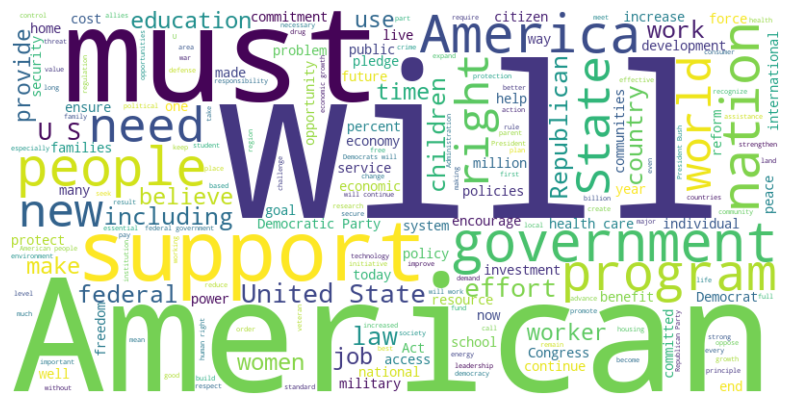

In [57]:
textprocess.word_cloud()